![Spotify](Spotify.png)

***Table of contents***

- **Data Exploration and Preprocessing**

- **PCA**

- **K-Means**
            - Using Elbow Plot to Find K
            - Performance Evaluation and Clustering Precision
            - Semi-supervised -- SVM + K-Means

- **DBSCAN**

            - Parameter Selections
            - Implementation and Clustering Precision


- **Gaussian Mixture**

            - Parameter Selection and Implementation
            - Semi-supervised Learning 1 -- Learning Initial GMM Parameters
            - Semi-supervised Learning 2 -- SVM + GMM


- **Hierachical Clustering -- Agglomerative Clustering**

            - Different Measurement of Distance Between Clusters
            - Implementation and Evaluation

- **Final Thoughts**

In [4]:
#import dtale
import pandas as pd
import numpy as np
import sklearn
import dtale
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster
from sklearn.mixture import GaussianMixture as GMM
from numpy import savetxt
from sklearn.cluster import AgglomerativeClustering

## Intro

### Dataset Basic Info
For the following analysis we use data on ~233k Spotify songs from Zaheen Hamidani

It comprises the following information for each song:

genre: genre of the track; in total there are 26 genres

artist name: name of the artist

track name: name of the track

track id: Spotify ID for the track

popularity: measure between 0 and 100, with 100 being the most popular track; the popularity is calculated by an algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are

acousticness: confidence measure from 0 to 1 of whether the track is acoustic; 1 represents high confidence of the track being acoustic

danceability: danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity; a value of 0 is least danceable and 1 is most danceable

duration: duration of the track in milliseconds

energy: measure from 0 to 1 representing a perceptual measure of intensity and activity; typically, energetic tracks feel fast, loud, and noisy; for example, death metal has high energy, while a Bach prelude scores low on the scale; perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy

instrumentalness: measure from 0 to 1 representing the absence of vocal elements; “ooh” and “aah” sounds are treated as instrumental in this context; rap or spoken word tracks are clearly “vocal”; the closer the instrumentalness value is to 1, the greater likelihood the track contains no vocal content; values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1

key: key the track is in; integers map to pitches using standard pitch class notation, e.g., 0 = C, 1 = C♯/D♭, 2 = D, and so on

liveness: detects the presence of an audience in the recording; higher liveness values represent an increased probability that the track was performed live; a value above 0.8 provides strong likelihood that the track is live

loudness: the overall loudness of a track in decibels (dB); loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks; Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude); values typical range between -60 and 0 db

mode: indicates the modality (major or minor) of a track

speechiness: detects the presence of spoken words in a track; the more exclusively speech-like the recording (e.g., talk show, audio book, poetry), the closer to 1.0 the attribute value; values above 0.66 describe tracks that are probably made entirely of spoken words; values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music; values below 0.33 most likely represent music and other non-speech-like tracks

tempo: overall estimated tempo of a track in beats per minute (BPM); in musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

time signature: estimated overall time signature of a track; the time signature (meter) is a notational convention to specify how many beats are in each bar (or measure)

valence: measure from 0 to 1 describing the musical positiveness; tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).

note that the underlying data set is labeled (see genre feature)

in order to enable full unsupervised learning and semi-supervised learning we will have two different version of the data (labeled and unlabeled after having carried out the preprocessing steps the labels of interest are represented by the genre column

### Analysis Purpose

P1

Compare Four Types of Clustering Methods:

- Centroid based clustering: K-means

- Density based clustering: DBSCAN

- Distribution based clustering: Gaussian Mixture

- Hierarchical Clustering: Agglomerative Clustering

P2

Semi-supervised Learning

## Data Exploration and Preprocessing

In [2]:
# load raw data
df = pd.read_csv("SpotifyFeatures.csv")

In [5]:
dtale.show(df)

2021-05-25 13:37:29,463 - INFO     - NumExpr defaulting to 4 threads.


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/dtale/views.py:1723: FutureWarning:

The default value of regex will change from True to False in a future version.



In [3]:
# print data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232725 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [4]:
# display first rows
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [7]:
df.groupby('genre').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
genre,,,,,,,,,,,
A Capella,9.302521,0.829941,0.412252,204467.697479,0.250313,0.007491,0.136924,-13.660387,0.042414,111.518950,0.328724
Alternative,50.213430,0.162313,0.541898,233241.364245,0.711519,0.061303,0.196985,-6.540803,0.088783,122.534485,0.449590
Anime,24.258729,0.286843,0.472090,229937.067927,0.665356,0.280592,0.192391,-7.917802,0.065102,126.629156,0.441682
Blues,34.742879,0.327840,0.528232,251931.826000,0.606171,0.095175,0.233125,-9.053807,0.061809,121.137637,0.579425
Children's Music,4.252637,0.591781,0.697475,142726.774200,0.396880,0.143572,0.164894,-11.641760,0.117279,121.131288,0.675956
Children’s Music,54.659040,0.163175,0.541843,232554.443601,0.706616,0.054340,0.195015,-6.526668,0.086489,121.931104,0.449237
Classical,29.282195,0.868843,0.305958,310339.983578,0.177984,0.599425,0.162810,-21.544477,0.052001,104.341807,0.214463
Comedy,21.342630,0.793098,0.559038,235305.210102,0.676094,0.000574,0.724775,-11.689321,0.853532,98.235488,0.412764
Country,46.100416,0.270172,0.577038,217237.527008,0.636318,0.005610,0.187216,-7.341693,0.048989,123.414419,0.535160


In [5]:
for i in list(df.columns):
    print(f"feature: {i}")
    print(df[i].unique())
    print(f"unique values: {len(df[i].unique())}")
    print("\n")

feature: genre
['Movie' 'R&B' 'A Capella' 'Alternative' 'Country' 'Dance' 'Electronic'
 'Anime' 'Folk' 'Blues' 'Opera' 'Hip-Hop' "Children's Music"
 'Children’s Music' 'Rap' 'Indie' 'Classical' 'Pop' 'Reggae' 'Reggaeton'
 'Jazz' 'Rock' 'Ska' 'Comedy' 'Soul' 'Soundtrack' 'World']
unique values: 27


feature: artist_name
['Henri Salvador' 'Martin & les fées' 'Joseph Williams' ... 'Dharmasoul'
 'Swim' 'Jr Thomas & The Volcanos']
unique values: 14564


feature: track_name
["C'est beau de faire un Show" "Perdu d'avance (par Gad Elmaleh)"
 "Don't Let Me Be Lonely Tonight" ... 'P.O.P.' 'Burning Fire'
 "You Don't Have To Hurt No More"]
unique values: 148615


feature: track_id
['0BRjO6ga9RKCKjfDqeFgWV' '0BjC1NfoEOOusryehmNudP'
 '0CoSDzoNIKCRs124s9uTVy' ... '2iZf3EUedz9MPqbAvXdpdA'
 '1qWZdkBl4UVPj9lK6HuuFM' '34XO9RwPMKjbvRry54QzWn']
unique values: 176774


feature: popularity
[  0   1   3   4   2  15  10   8   5   6   7  11  65  63  62  61  68  64
  66  60  69  71  76  67  70  72  57  59  56  2

In [6]:
# harmonizing all variations of the children's music genre
df["genre"] = np.where((df.genre == "Children’s Music"),"Children's Music", df.genre)

In [7]:
# picking the first duplicate track ID
duplicates = df["track_id"].duplicated()
duplicate_id = df[duplicates == True]["track_id"].iloc[0]

# get data entries for that track ID
df[df["track_id"] == duplicate_id]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
257,R&B,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
1348,Alternative,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
77710,Children's Music,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
93651,Indie,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7
113770,Pop,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7


In [8]:
# removing all duplicate appearances of tracks
df = df.drop_duplicates(subset="track_id", keep="first")

# reset index
df = df.reset_index(drop=True)

# check result
df[df["track_id"] == duplicate_id]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
257,R&B,Doja Cat,Go To Town,6iOvnACn4ChlAw4lWUU4dd,64,0.0716,0.71,217813,0.71,0.000001,C,0.206,-2.474,Major,0.0579,169.944,4/4,0.7


Text(0, 0.5, 'Occurences')

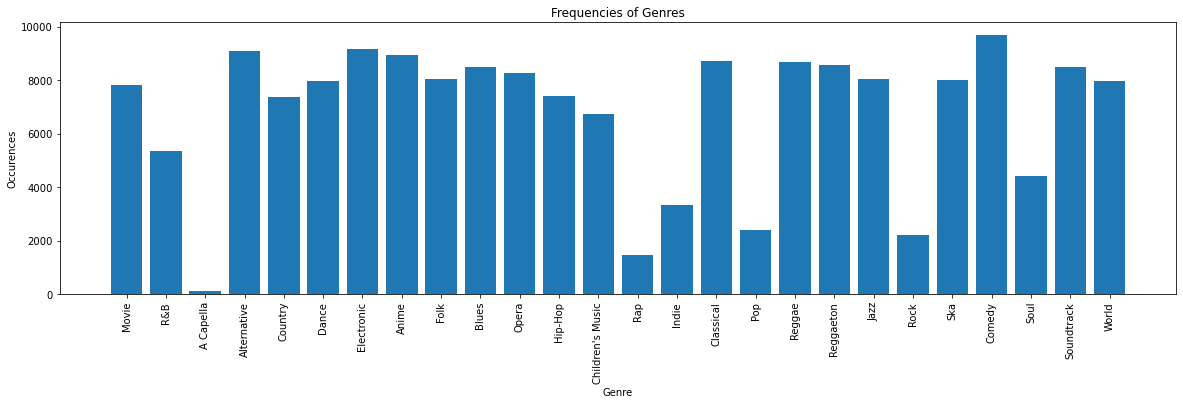

In [9]:
# calculate % of genre affiliation
genres = df["genre"].unique()

counts = {}

for genre in genres:
    counts[genre] = df[df["genre"] == genre]["genre"].count()

# plot the distribution over genres
fig = plt.figure(figsize=(20,5))
plt.bar(list(counts.keys()), counts.values())
plt.title("Frequencies of Genres")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.ylabel("Occurences")

In [10]:
# dropping key and time signature features
df = df.drop(["key", "time_signature"], axis=1)

In [11]:
# one-hot-encoding mode feature
ohe = pd.get_dummies(df["mode"])
ohe = ohe.rename(columns = {"Major": "mode_ohe"})
ohe = ohe["mode_ohe"]

# drop original mode feature
if "mode" in list(df.columns):
    del df["mode"]

# concatenate one-hot-encoding colum
df = pd.concat([df, ohe], axis = 1)

In [12]:
# Drop A Capella
# len(df[df["genre"] == 'A Capella']) == 119
df_Acapella = df.loc[df["genre"] == 'A Capella']
df = df.drop(df_Acapella.index, axis=0)
df.shape

(176655, 16)

In [13]:
# create separate table with additional information
# Drop the acousticness and energy because they are highly correlated with other features
df_aux = df[["artist_name", "track_name", "track_id",'acousticness','energy', "genre"]]

# save auxiliary table
df_aux.to_csv("auxiliary_data.csv", index = False)

# drop corresponding features, except label
df = df.drop(["artist_name", "track_name", "track_id",'acousticness','energy'], axis=1)


In [14]:
# create table for labels
labels = df[["genre"]]

# # drop labels from data set
df = df.drop(["genre"], axis=1)

# standardization of all continuous variables
sc = StandardScaler()
cont_var = df.iloc[:,:-1]
X = pd.DataFrame(sc.fit_transform(cont_var), columns = cont_var.columns)
X = X.assign(mode_ohe = list(df.mode_ohe))

# concatenate the binary variable
#X = pd.concat([X, df.iloc[:,-1]], axis = 1)

# # save preprocessed data
X.to_csv("preprocessed_data.csv", index = False)

In [15]:
X.shape

(176655, 10)

## PCA

In [16]:
df_unlabeled = pd.read_csv("preprocessed_data.csv")
df_unlabeled.shape

(176655, 10)

In [17]:
# Select n-components = 8 as taken from Baby Giraffes codes
pca = PCA(n_components=8)
df_unlabeled_pca = pd.DataFrame(pca.fit_transform(df_unlabeled))
df_labeled_pca = df_unlabeled_pca.assign(genre = list(labels.genre))
# label encoding genre
# label_encoder = LabelEncoder()
# df_labeled_pca[['genre']] = label_encoder.fit_transform(df_labeled_pca[['genre']])
df_labeled_pca.tail()

,0,1,2,3,4,5,6,7,genre
176650,-1.665719,-0.124855,-0.363769,0.790433,0.506516,-0.075372,-0.348921,-0.133189,Soul
176651,-1.498857,-0.524655,-0.001815,-1.097937,-0.103664,0.696874,1.345161,-0.103384,Soul
176652,0.427945,0.310482,-0.742520,0.727108,-0.368578,-0.908700,-0.467149,0.582554,Soul
176653,-1.921399,-0.288278,-0.332752,0.497305,1.234926,0.254755,-0.448670,0.546748,Soul
176654,-0.911444,-0.664650,0.296467,0.527043,0.811220,-0.291671,0.406513,-0.463135,Soul


## Final Dataset Preparation

In [8]:
# After shuffelling the dataframe, save for unsupervised clustering
# df_clustering = pd.DataFrame(df_unlabeled_pca).sample(frac=1)
# df_clustering.to_csv("clustering_data.csv")

# Directly load the data 
df_clustering = pd.read_csv("clustering_data.csv")
df_clustering.set_index(df_clustering.iloc[:,0],inplace=True)
df_clustering.index.name = 'Index'
df_clustering = df_clustering.iloc[:,1:9]

# save for semi-supervised 
# df_semi = df_labeled_pca.sample(frac = 1)
# df_semi.to_csv("semi_supervised_data.csv")

# Directly load the data 
df_semi = pd.read_csv("semi_supervised_data.csv")
df_semi.set_index(df_semi.iloc[:,0],inplace=True)
df_semi.index.name = 'Index'
df_semi = df_semi.iloc[:,1:10]

# Train/Test Set for semi_supervised learning
# 20%  for test set -- labeled
# 80% * 20% = 16% used for labeled training set
# 80% * 80% = 64% used for unlabeled training set
subset_X = df_semi.drop(['genre'], axis=1)
subset_y = df_semi.genre
X_train, X_test, y_train, y_test = train_test_split(subset_X, subset_y, test_size=0.2, random_state=1)
X_train_semi, X_unl_semi, y_train_semi, y_unl_semi = train_test_split(X_train, y_train, test_size=0.80, random_state=1)

## K-Means

### Using Elbow Plot to Find K

- Elbow method gives us an idea on what a good k number of clusters would be based on the sum of squared distance (SSE) between data points and their assigned clusters’ centroids. We pick k at the spot where SSE starts to flatten out and forming an elbow.

- The K-mean algorithm aims to select centroids that minimise the inertia, or within-cluster sum of squre criterion

$\sum_{i=1}^{n}$min($||x_{i} - \mu_{j}||^{2}$)

- [source](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)

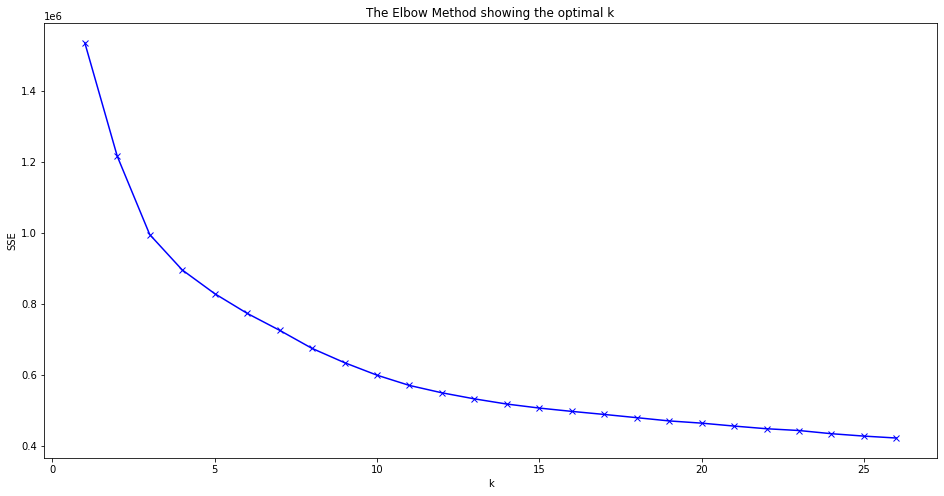

In [29]:
sse = []
list_k = range(1,27)

for k in list_k:
    km = KMeans(n_clusters=k,max_iter=30) #  max_iter default = 300
    km.fit(df_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(16,8))
plt.plot(list_k, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Conditional Probability and Performance Evaluation

**Evaluation Scores**


**Silhouette coefficients** 

- Silhouette coefficients can be used to determine the degree of separation between clusters:

- $a^{i}$:The mean distance between a sample and all other points in the same cluster.
- $b^{i}$ :The mean distance between a sample and all other points in the next nearest cluster.

- Silhouette coefficients = $\frac{b^{i}-a^{i}}{max(a^{i},b^{i})}$

- near +1 indicate that the sample is far away from the neighboring clusters.
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
- negative values indicate that those samples might have been assigned to the wrong cluster




**Calinski-Harabasz Index¶**

- Higher score indicates the clusters are dense and well separated

- Ratio = Between Clusters Dispersion / Within cluster Dispersion




**Davies-Bouldin Index**

- The index signifies the average similarity between clusters

- A lower score indicates a better separation between the clusters

[source](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [8]:
def evaluation_scores(df_clustering,labels_):
    s1=metrics.silhouette_score(df_clustering,labels_, metric='euclidean')
    s2=metrics.calinski_harabasz_score(df_clustering,labels_)
    s3=metrics.davies_bouldin_score(df_clustering,labels_)
    print(f"Silhouette coefficients:{round(s1,3)}\n Calinski-Harabasz Index:{round(s2,3)}\n Davies-Bouldin Index:{round(s3,3)}.")

In [31]:
km = KMeans(n_clusters=5,random_state=1).fit(df_clustering)
km_labels = km.labels_

In [32]:
evaluation_scores(df_clustering,km_labels)

Silhouette coefficients:0.173
 Calinski-Harabasz Index:37632.901
 Davies-Bouldin Index:1.565.


In [33]:
km = KMeans(n_clusters=10,random_state=1).fit(df_clustering)
km_labels = km.labels_

In [34]:
evaluation_scores(df_clustering,km_labels)

Silhouette coefficients:0.178
 Calinski-Harabasz Index:30642.161
 Davies-Bouldin Index:1.389.


In [35]:
km = KMeans(n_clusters=25,random_state=1).fit(df_clustering)
km_labels = km.labels_

In [36]:
evaluation_scores(df_clustering,km_labels)

Silhouette coefficients:0.134
 Calinski-Harabasz Index:18998.152
 Davies-Bouldin Index:1.617.


**Clustering Precision**

In [9]:
kmeans = KMeans(n_clusters=25, max_iter=10000)
X_dist = kmeans.fit_transform(df_semi.iloc[:,:-1]) 
representative_idx = np.argmin(X_dist, axis=1)

In [10]:
column_names = ["genre", "cluster"]
spotify_df = pd.DataFrame(columns = column_names)
spotify_df['genre'] = df_semi.genre
spotify_df['cluster']=list(representative_idx)

In [11]:
amount_genres = []
points_per_cluster = []

for k in range(0, 1):
    number_of_points = spotify_df['genre'].loc[spotify_df['cluster'] == k].nunique()
    unique_genres = spotify_df['genre'].loc[spotify_df['cluster'] == k].unique()

    amount_genres.append(len(unique_genres))
    points_per_cluster.append(number_of_points)

In [12]:
matrix_of_truth = pd.crosstab(spotify_df['genre'], spotify_df['cluster'])
matrix_of_truth_columns = pd.crosstab(spotify_df['genre'], spotify_df['cluster'], normalize='columns')
matrix_normalized = pd.DataFrame(matrix_of_truth_columns)
#setting a threshold of 3% ir that conditional probability is below we set it to zero
first_lambda  = lambda x: 0 if x < 0.03 else x
matrix_normalized = matrix_normalized.applymap(first_lambda)
second_lambda = lambda r: r/r.sum()
matrix_normalized = matrix_normalized.apply(second_lambda, axis=0)
pd.set_option('display.max_columns', None)
matrix_normalized

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
genre,,,,,,,,,,,,,,,,,,,,,,,,,
Alternative,0.000000,0.141726,0.000000,0.0,0.084822,0.055275,0.057441,0.166570,0.000000,0.112789,0.057719,0.000000,0.0,0.095058,0.000000,0.175363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045766,0.000000,0.000000
Anime,0.000000,0.000000,0.036433,0.0,0.000000,0.037741,0.048833,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.233139,0.123336,0.139661,0.152385,0.000000,0.000000,0.000000,0.166944,0.037586,0.000000,0.124663
Blues,0.000000,0.062396,0.000000,0.0,0.000000,0.139970,0.043039,0.000000,0.000000,0.078153,0.088339,0.000000,0.0,0.000000,0.114547,0.098699,0.055220,0.000000,0.124159,0.000000,0.074818,0.117655,0.162945,0.000000,0.000000
Children's Music,0.560781,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052932,0.000000,0.137243,0.000000,0.000000,0.000000,0.000000,0.051082,0.000000,0.145777,0.000000
Classical,0.000000,0.000000,0.427421,0.0,0.000000,0.064785,0.000000,0.000000,0.519870,0.000000,0.000000,0.152473,0.0,0.000000,0.000000,0.000000,0.063079,0.186868,0.000000,0.052632,0.456204,0.000000,0.000000,0.000000,0.151977
Comedy,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.378947,0.069343,0.000000,0.000000,0.638283,0.000000
Country,0.000000,0.104086,0.000000,0.0,0.044590,0.000000,0.000000,0.117905,0.000000,0.080639,0.108981,0.000000,0.0,0.035347,0.000000,0.095027,0.000000,0.000000,0.075055,0.000000,0.000000,0.084240,0.036701,0.000000,0.000000
Dance,0.000000,0.058531,0.000000,0.0,0.128105,0.000000,0.000000,0.134016,0.000000,0.097869,0.081100,0.000000,0.0,0.227865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Electronic,0.000000,0.050156,0.000000,0.0,0.043863,0.066270,0.392319,0.077997,0.000000,0.070693,0.066425,0.000000,0.0,0.000000,0.054003,0.116603,0.139460,0.033863,0.043338,0.063158,0.000000,0.045065,0.076056,0.000000,0.000000


Executing shutdown due to inactivity...


2021-05-25 14:44:51,847 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2021-05-25 14:44:51,892 - INFO     - Executing shutdown...


<div class="alert alert-block alert-info">
<b>Comment:</b> 

- Though we know from the original dataset that there should be 25 genres, the Silhouette coefficients for 10 clusters K-means is higher than that of 25 clusters k-means, which may indicate that there are lots of similarities and noises exit. Such is the truth in reality, as we may identify one song belonging to more than one genres.
    
    
- From the table above we can see the K-Means identifies the Comedy Genre very well. It can be partly inferred from the features of the comedy genre that its average instrumentallness is far below the overall average, speechiness is far above the overall average and its tempo average is this only one genre that below 100.
    
    
    
- Though K-means can clearly identifies Comedy, it separates the comedy into two groups

</div>

### Semi-supervised K-Means

- We will perform a classification problem using SVM to get a score used as benchmark

- STEPs of Semi-supervised learning

        1.Train the model with the small amount of labeled training data just like you would in supervised learning, until it gives you good results.
        
        2.Then use it with the unlabeled training dataset to predict the outputs, which are pseudo labels since they may not be quite accurate.
        
        3.Link the labels from the labeled training data with the pseudo labels created in the previous step.
        
        4.Link the data inputs in the labeled training data with the inputs in the unlabeled data.
        
        5.Then, train the model the same way as you did with the labeled set in the beginning in order to decrease the error and improve the model’s accuracy.

    
    

In [11]:
# Caution: Running this cell on WRDS Cloud costs more than 10 mins
# SVM as classification
# Results are used for comparison with semi-supervised learning, 
# No need for improvement
svm_rbf = svm.SVC(kernel = 'rbf', gamma = "auto", C = 1.0)
svm_rbf.fit(X_train, y_train)

y_train_pred = svm_rbf.predict(X_train)
y_test_pred = svm_rbf.predict(X_test)

k1=accuracy_score(y_train, y_train_pred)
print("Train_set_results:", k1)
k2 = accuracy_score(y_test, y_test_pred)
print("Test_set_results:", k2)

Train_set_results: 0.4916503920070193
Test_set_results: 0.48127706546658744


In [4]:
# Now the first step of Semi-supervised learning
# Perform SVM on the labeled training set
svm_rbf = svm.SVC(kernel = 'rbf', gamma = "auto", C = 1.0)
svm_rbf.fit(X_train_semi, y_train_semi)

y_train_pred = svm_rbf.predict(X_train_semi)
y_test_pred = svm_rbf.predict(X_test)

k1=accuracy_score(y_train_semi, y_train_pred)
print("Train_set_results:", k1)
k2 = accuracy_score(y_test, y_test_pred)
print("Test_set_results:", k2)

Train_set_results: 0.47233229549957545
Test_set_results: 0.46021907107073107


In [13]:
# Use unlabed data to run clustering to generate pseudo-labels
kmeans = KMeans(n_clusters=25)
X_dist = kmeans.fit_transform(X_unl_semi) 
representative_idx = np.argmin(X_dist, axis=0) 
X_representative = X_unl_semi.values[representative_idx]

- X_dist is the distance matrix to the cluster centroids. 

- Representative_idx is the index of the data points that are closest to each cluster centroid.

- Next, we collected the true labels of these data points:extracting the labels from the raw data.

- In reality, we may need to manually labeled the centroid according to the SVM model labels

In [14]:
# We need to find the relationship between kmeans labels (pseudo lables)and original real labels
# In real cases, we need manually attach labels to each group identified/grouped together by the k-means
y_representative = [list(y_unl_semi)[x] for x in representative_idx]
KM_lables = [list(kmeans.labels_)[i] for i in list(representative_idx)]
print(y_representative)# True
print(KM_lables)# Pseudo

['Anime', 'World', 'Classical', 'Comedy', 'Folk', 'Anime', 'Opera', 'Hip-Hop', 'Classical', 'Reggae', 'Classical', 'World', 'Classical', 'Comedy', 'Indie', 'Movie', 'Comedy', 'Reggae', 'World', 'Electronic', 'Rap', 'Classical', 'Anime', 'Soul', 'Comedy']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [15]:
# mapping the Pseudo with True labels
df_KM_semi = pd.DataFrame(X_unl_semi)
df_KM_semi['km_labels'] = kmeans.labels_
df_KM_semi['genre'] = np.zeros(len(X_unl_semi))
for i in KM_lables:
    df_KM_semi.loc[df_KM_semi['km_labels'] == i, 'genre'] = y_representative[i]
df_KM_semi = df_KM_semi.drop(['km_labels'],axis=1)

In [16]:
df_train_semi = pd.concat([X_train_semi,y_train_semi],axis = 1)
df_KM_semi = pd.concat([df_train_semi,df_KM_semi],axis = 0)

In [17]:
# Caution: Running this cell on WRDS Cloud costs more than 10 mins
svm_rbf = svm.SVC(kernel = 'rbf', gamma = "auto", C = 1.0)
svm_rbf.fit(df_KM_semi.iloc[:,:-1], df_KM_semi['genre'])

y_train_pred = svm_rbf.predict(df_KM_semi.iloc[:,:-1])
y_test_pred = svm_rbf.predict(X_test)

k1=accuracy_score(df_KM_semi['genre'], y_train_pred)
print("Train_set_results:", k1)
k2 = accuracy_score(y_test, y_test_pred)
print("Test_set_results:", k2)

Train_set_results: 0.8125937561914466
Test_set_results: 0.22224109139282783


<div class="alert alert-block alert-info">
<b>Comment:</b>
    
- The training-set accuracy score achieved by Semi-supervised learning is much higher than the mere supervised learining classifier but the test-set accuracy score is much lower than before
    
    
- From the mapping relationship between pseudo-labels generated by K-means and the real labels,we can see that K-Means identified more than one groups of the genres like Comedy, classical and failed to identify genres such as Country, Children's Music, Blues.
    

</div>

## DBSCAN

### Parameter Selection
- Minimum samples (“MinPts”): the fewest number of points required to form a cluster
    
    
- ε (epsilon or “eps”): the maximum distance two points can be from one another while still belonging to the same cluster


- If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).


- One technique to automatically determine the optimal ε value is described in this paper(link below). This technique calculates the average distance between each point and its k nearest neighbors, where k = the MinPts value you selected.


[source1](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf)


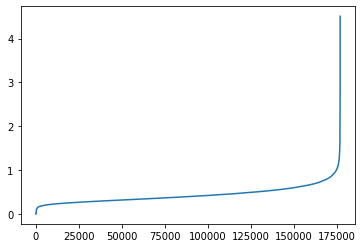

In [18]:
# MinPts = 2*12 = 24
# Calculate the average distance between each point in the dataset and its 24 nearest neighbors
neighbors = NearestNeighbors(n_neighbors=24)
neighbors_fit = neighbors.fit(df_clustering)
distances, indices = neighbors_fit.kneighbors(df_clustering)
# Sort the distance values by ascending value and plot
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

### Implementation and Clustering Precision

In [20]:
epsilon = 1.0
min_samples = 24
dbscan = cluster.DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_semi.iloc[:,:-1])

In [9]:
evaluation_scores(df_semi.iloc[:,:-1],dbscan_labels)

Silhouette coefficients:0.32
 Calinski-Harabasz Index:16119.51
 Davies-Bouldin Index:2.407.


In [21]:
# Check how many groups are identified by DBSCAN
unique, counts = np.unique(dbscan_labels, return_counts=True)
dict(zip(unique, counts))

{-1: 8289, 0: 160106, 1: 8260}

- Though the Silhouette Coefficients is relatively higher than the other clustering methods, DBSCAN only genereated 3 groups of music, which is far less than the original 25 genres of music

- Is it possible that we use an epsilon too large? Try smaller one as 0.5

In [18]:
epsilon = 0.5
min_samples = 24
dbscan = cluster.DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_semi.iloc[:,:-1])
unique, counts = np.unique(dbscan_labels, return_counts=True)
dict(zip(unique, counts))

{-1: 115372,
 0: 58031,
 1: 2506,
 2: 599,
 3: 35,
 4: 40,
 5: 13,
 6: 24,
 7: 24,
 8: 11}

- Though with smaller Epsilon, we have 9 clusters, the majority of the music is still grouped in the first 3 clusters.Changing Epsilon does not solve the problem fundamentally

- **Let's cross-tab as before to see what genres of music DBSCAN grouped together**

**Clustering Precision**

In [23]:
column_names = ['genre','dbscan_labels']
dbscan_clustering_precision = pd.DataFrame(columns = column_names)
dbscan_clustering_precision['genre'] = df_semi.genre
dbscan_clustering_precision['dbscan_labels'] = list(dbscan_labels)

matrix_of_truth_columns = pd.crosstab(dbscan_clustering_precision['genre'], dbscan_clustering_precision['dbscan_labels'], normalize='columns')
matrix_normalized = pd.DataFrame(matrix_of_truth_columns)
#setting a threshold of 3% ir that conditional probability is below we set it to zero
first_lambda  = lambda x: 0 if x < 0.03 else x
matrix_normalized = matrix_normalized.applymap(first_lambda)
second_lambda = lambda r: r/r.sum()
matrix_normalized = matrix_normalized.apply(second_lambda, axis=0)
matrix_normalized

dbscan_labels,-1,0,1
genre,,,
Alternative,0.000000,0.061383,0.0
Anime,0.038950,0.059369,0.0
Blues,0.064333,0.055150,0.0
Children's Music,0.068709,0.042472,0.0
Classical,0.168490,0.051746,0.0
Comedy,0.157695,0.000000,1.0
Country,0.000000,0.050383,0.0
Dance,0.000000,0.054075,0.0
Electronic,0.095697,0.058164,0.0


<div class="alert alert-block alert-info">
<b>Comment:</b> 
    
- The crosstab rowise sum should be 1 -- check later
   
- DBSCAN can only identify comedy

</div>

## Gaussian Mixture

### Parameter Selection and Implementation

**Covariance Choice**

- This hyperparameter controls the degrees of freedom in the shape of each cluster


- The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes


- A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. 


- A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation.

**Number of Components**

*BIC*

*Bayesian information criterion (BIC)*


- This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have. 

- The lower is the BIC, the better is the model to actually predict the data we have

- In order to avoid overfitting, this technique penalizes models with big number of clusters.

- Technically, we have to calculate the gradient of the BIC scores curve and select the cluster number wherer the gradient begins to flatten


Text(0.5, 0, 'n_components')

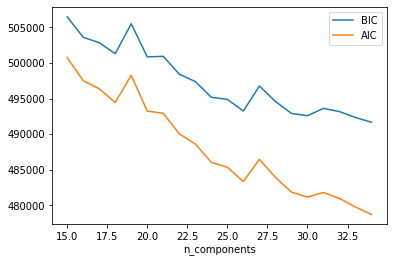

In [14]:
# Caution: Running this cell on WRDS clouds using only 20% of the samples costs around 5mins
GMM_subset =df_clustering.sample(frac = 0.2,random_state=0)
n_components = np.arange(15, 35)
models = [GMM(n, covariance_type='full', random_state=0,max_iter=500).fit(GMM_subset)for n in n_components]

plt.plot(n_components, [m.bic(GMM_subset) for m in models], label='BIC')
plt.plot(n_components, [m.aic(GMM_subset) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [15]:
gmm_base = GMM(n_components=25, covariance_type='full', random_state=0)
gmm_base.fit(df_semi.iloc[:,:-1])
gmm_labels = gmm_base.predict(df_semi.iloc[:,:-1])
evaluation_scores(df_semi.iloc[:,:-1],gmm_labels)

Silhouette coefficients:-0.006
 Calinski-Harabasz Index:9171.651
 Davies-Bouldin Index:2.849.


- Since Silhouette coefficients equals zero which tells us that the GMM clustering methods does not really work. 

- Let's run the cross tab to see whether GMM can group the same genre of music together

**Clustering Precision**

In [16]:
column_names = ['genre','gmm_labels']
gmm_clustering_precision = pd.DataFrame(columns = column_names)
gmm_clustering_precision['genre'] = df_semi.genre
gmm_clustering_precision['gmm_labels'] = list(gmm_labels)

matrix_of_truth_columns = pd.crosstab(gmm_clustering_precision['genre'], gmm_clustering_precision['gmm_labels'], normalize='columns')
matrix_normalized = pd.DataFrame(matrix_of_truth_columns)
#setting a threshold of 3% ir that conditional probability is below we set it to zero
first_lambda  = lambda x: 0 if x < 0.03 else x
matrix_normalized = matrix_normalized.applymap(first_lambda)
second_lambda = lambda r: r/r.sum()
matrix_normalized = matrix_normalized.apply(second_lambda, axis=0)
matrix_normalized

gmm_labels,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
genre,,,,,,,,,,,,,,,,,,,,,
Alternative,0.000000,0.000000,0.057099,0.0,0.109077,0.080914,0.000000,0.000000,0.000000,0.062252,...,0.000000,0.000000,0.071666,0.084285,0.073450,0.079238,0.000000,0.059865,0.000000,0.000000
Anime,0.043282,0.045665,0.038292,0.0,0.085631,0.047354,0.000000,0.133553,0.000000,0.000000,...,0.118425,0.000000,0.059081,0.070394,0.000000,0.000000,0.000000,0.062019,0.000000,0.058604
Blues,0.162426,0.000000,0.057777,0.0,0.051245,0.152769,0.000000,0.038053,0.051685,0.000000,...,0.000000,0.142857,0.105751,0.083167,0.055912,0.000000,0.000000,0.079255,0.165437,0.000000
Children's Music,0.068490,0.000000,0.000000,0.0,0.000000,0.000000,0.158844,0.064398,0.000000,0.000000,...,0.048447,0.000000,0.000000,0.000000,0.063379,0.000000,0.619344,0.049400,0.106193,0.000000
Classical,0.000000,0.363370,0.061166,0.0,0.000000,0.000000,0.000000,0.200512,0.123596,0.000000,...,0.249187,0.133108,0.000000,0.000000,0.000000,0.000000,0.000000,0.034010,0.000000,0.242039
Comedy,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.491837,0.000000,0.370787,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Country,0.090844,0.000000,0.000000,0.0,0.092553,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.040902,0.195174,0.000000,0.000000,0.000000,0.000000,0.046501,0.000000
Dance,0.000000,0.000000,0.000000,0.0,0.141454,0.000000,0.000000,0.000000,0.000000,0.078603,...,0.000000,0.000000,0.061353,0.067805,0.046189,0.072885,0.000000,0.000000,0.000000,0.000000
Electronic,0.000000,0.000000,0.000000,0.0,0.000000,0.097179,0.000000,0.000000,0.035955,0.065756,...,0.137042,0.300337,0.082153,0.000000,0.036812,0.000000,0.000000,0.175131,0.000000,0.000000


<div class="alert alert-block alert-info">
<b>Comment:</b> </div>

### Semi-supervised GMM 1 -- Using Labeled Data to learn initial GMM Parameters

We use the labeled data to learn the parameters of the Gaussian Mixture Distribution

- weights_init: The weights of each mixture components.

- means_init: The mean of each mixture component.

- precisions_init: The precision matrices for each component in the mixture. A precision matrix is the inverse of a covariance matrix. A covariance matrix is symmetric positive definite so the mixture of Gaussian can be equivalently parameterized by the precision matrices.


In [62]:
def learn_params(x_labeled, y_labeled):
    n = x_labeled.shape[0]
    phi_list = []
    mu_list = []
    sigma_list = []   
    for i in list(df_semi.genre.unique()):
        phi = x_labeled[y_labeled == i].shape[0] / n
        mu  = np.sum(x_labeled[y_labeled == i], axis=0) / x_labeled[y_labeled == i].shape[0]
        sigma = np.cov(x_labeled[y_labeled == i].T, bias= True)
        phi_list.append(phi)
        mu_list.append(mu)
        sigma_list.append(sigma)
    return {'phi': phi_list, 'mu': mu_list,'sigma': sigma_list}

In [63]:
# use 16% of the total data to learn the initial parameters
# Caution: this cell costs around 5mins to run on WRDS cloud
learned_params = learn_params(X_train_semi, y_train_semi)
weights = learned_params["phi"]
means = learned_params["mu"]
covariances = learned_params["sigma"]
gmm_semi_model = GMM(n_components=25,
                    covariance_type='full',
                    tol=0.01,
                    max_iter=1000,
                    weights_init=weights,
                    means_init=means,
                    precisions_init=covariances)

# use the whole data set df_ clustering to fit the model and get the evaluation score
# so that the evaluation scores are comparable to the gmm_base
gmm_semi_model.fit(df_semi.iloc[:,:-1])
labels_semi_gmm = gmm_semi_model.predict(df_semi.iloc[:,:-1])
evaluation_scores(df_semi.iloc[:,:-1],labels_semi_gmm)

Silhouette coefficients:0.029
 Calinski-Harabasz Index:8632.004
 Davies-Bouldin Index:2.963.


A bit better, but still crap

In [64]:
column_names = ['genre','labels_semi_gmm']
semi_gmm_clustering_precision = pd.DataFrame(columns = column_names)
semi_gmm_clustering_precision['genre'] = df_semi.genre
semi_gmm_clustering_precision['labels_semi_gmm'] = list(labels_semi_gmm)

matrix_of_truth_columns = pd.crosstab(semi_gmm_clustering_precision['genre'], semi_gmm_clustering_precision['labels_semi_gmm'], normalize='columns')
matrix_normalized = pd.DataFrame(matrix_of_truth_columns)
#setting a threshold of 3% ir that conditional probability is below we set it to zero
first_lambda  = lambda x: 0 if x < 0.03 else x
matrix_normalized = matrix_normalized.applymap(first_lambda)
second_lambda = lambda r: r/r.sum()
matrix_normalized = matrix_normalized.apply(second_lambda, axis=0)
matrix_normalized

labels_semi_gmm,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
genre,,,,,,,,,,,,,,,,,,,,,
Alternative,0.110131,0.000000,0.038267,0.000000,0.056925,0.000000,0.077835,0.000000,0.000000,0.104869,...,0.000000,0.000000,0.0,0.000000,0.045876,0.102067,0.088509,0.000000,0.098849,0.078598
Anime,0.067161,0.000000,0.065704,0.146173,0.053991,0.048750,0.044848,0.048930,0.000000,0.084390,...,0.084288,0.126178,0.0,0.096737,0.037887,0.039224,0.000000,0.000000,0.000000,0.000000
Blues,0.070480,0.000000,0.135018,0.039012,0.117958,0.124926,0.085990,0.000000,0.080174,0.036082,...,0.000000,0.000000,0.0,0.000000,0.123969,0.053986,0.000000,0.212579,0.136323,0.000000
Children's Music,0.000000,0.201372,0.000000,0.108642,0.079225,0.162981,0.063380,0.000000,0.071456,0.000000,...,0.000000,0.062908,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Classical,0.000000,0.062551,0.128520,0.073580,0.000000,0.000000,0.000000,0.223751,0.092115,0.000000,...,0.251276,0.052030,0.0,0.388090,0.000000,0.000000,0.000000,0.076730,0.000000,0.000000
Comedy,0.000000,0.252675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Country,0.125182,0.000000,0.000000,0.000000,0.000000,0.079916,0.000000,0.000000,0.000000,0.085086,...,0.000000,0.000000,0.0,0.000000,0.039948,0.000000,0.000000,0.000000,0.000000,0.000000
Dance,0.085940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129632,...,0.000000,0.000000,0.0,0.000000,0.000000,0.036272,0.062345,0.000000,0.000000,0.085169
Electronic,0.000000,0.000000,0.085199,0.236543,0.122066,0.000000,0.188658,0.000000,0.000000,0.042352,...,0.000000,0.262509,0.0,0.000000,0.000000,0.429355,0.037596,0.314465,0.154913,0.080667


<div class="alert alert-block alert-info">
<b>Comment:</b> </div>

### Semi-supervised GMM 2 -- SVM + GMM

In [17]:
# Use GMM on the Unlabled Data to produce Pseudo-label
gmm_semi = GMM(n_components=25, covariance_type='full', random_state=0).fit(X_unl_semi)
gmm_labels_semi= gmm_semi.predict(X_unl_semi)

In [18]:
# Manully select the representative datapoints because we dont have the things like centroids
df_labels_semi = pd.DataFrame(gmm_labels_semi)
df_labels_semi.columns = ['gmm_labels']
selected_row_index = []
for i in range(0,25):
    idx = df_labels_semi.loc[df_labels_semi['gmm_labels'] == i].index[0]
    selected_row_index.append(idx)
# the selected index's corresponding real labels are
y_representative = [list(y_unl_semi)[x] for x in selected_row_index]

In [19]:
df_GMM_semi = pd.DataFrame(X_unl_semi)
df_GMM_semi['gmm_labels'] = gmm_labels_semi
df_GMM_semi['genre'] = np.zeros(len(X_unl_semi))

## Mapping the real with the pseudo-labels
n = 0
while n < len(y_representative):
    df_GMM_semi.loc[df_GMM_semi['gmm_labels'] == n, 'genre'] = y_representative[n]
    n +=1
    
df_GMM_semi = df_GMM_semi.drop(['gmm_labels'],axis=1)

In [20]:
# Conbine the labeled and unlabeled(pseudo labeled) together
df_train_semi = pd.concat([X_train_semi,y_train_semi],axis = 1)
df_GMM_semi = pd.concat([df_train_semi,df_GMM_semi],axis = 0)

# Run SVM again on the whole Training set with real+psedo labels
svm_rbf = svm.SVC(kernel = 'rbf', gamma = "auto", C = 1.0)
svm_rbf.fit(df_GMM_semi.iloc[:,:-1], df_GMM_semi['genre'])

y_train_pred = svm_rbf.predict(df_GMM_semi.iloc[:,:-1])
y_test_pred = svm_rbf.predict(X_test)

k1=accuracy_score(df_GMM_semi['genre'], y_train_pred)
print("Train_set_results:", k1)
k2 = accuracy_score(y_test, y_test_pred)
print("Test_set_results:", k2)

Train_set_results: 0.6772522713764116
Test_set_results: 0.17503042653760154


<div class="alert alert-block alert-info">
<b>Comment:</b> </div>

## Hierachical Clustering -- Agglomerative Clustering

### Differennt Measurement of Distance Between Clusters (Pros and Cons)

- Min/Single Linkage

            - Distance of two clusters equals to the two closest points that belongs to two clusters individually.
            - Can be used to separate non-elliptical shape
            - Does not perfome well when there is noises between clusters


- Max/Complete Linkage

        - Distance of two clusters equals to the two furthurest points that belongs to two clusters individually.
        - Less susceptible to noises and outliers but small clusters tend to be merged with larger ones


- Group Average/Average Link

        - Take all the pairs of points and compute their similarities and calculate the average of the similarities.
        - Less susceptible to noises

- Ward’s Method

        - Calculation is the same as the Group average except it uses the sum of square of the distance between pairs of points
        
- We use average and ward because there are noises and outliers

### Dendrogram to decide the number of Clusters

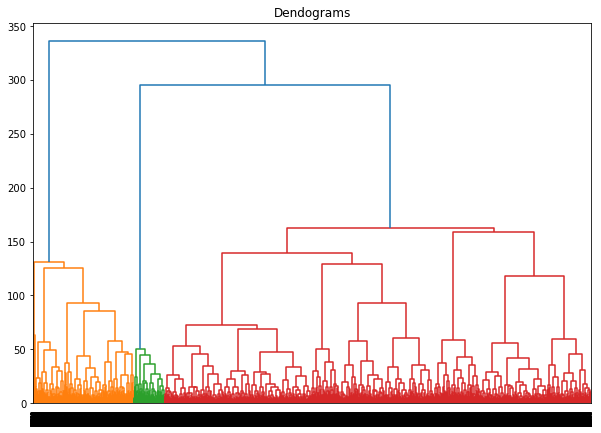

In [24]:
# Caution: this will run more than 5 mins
import scipy.cluster.hierarchy as shc
agglo_subset =df_semi.sample(frac = 0.2,random_state=0)
data = agglo_subset.iloc[:,:-1].values
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

### Implementation and Evaluation

In [65]:
# Caution: Running this cell on WRDS clouds using only 20% of the samples costs 3-4 mins
# If linkage is “ward”, only “euclidean” is accepted. 
agglo_subset =df_semi.sample(frac = 0.2,random_state=0)
Agglomerative = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward')
Agglomerative.fit(agglo_subset.iloc[:,:-1])
Agglo_labels_eud = Agglomerative.labels_

In [66]:
evaluation_scores(agglo_subset.iloc[:,:-1],Agglo_labels_eud)

Silhouette coefficients:0.077
 Calinski-Harabasz Index:2998.492
 Davies-Bouldin Index:1.806.


In [67]:
# Try using cosine distance
Agglomerative = AgglomerativeClustering(n_clusters=25, affinity='cosine', linkage='average')
Agglomerative.fit(agglo_subset.iloc[:,:-1])
Agglo_labels_cosine = Agglomerative.labels_
evaluation_scores(agglo_subset.iloc[:,:-1],Agglo_labels_cosine)

Silhouette coefficients:0.054
 Calinski-Harabasz Index:2037.787
 Davies-Bouldin Index:1.82.


In [69]:
column_names = ['genre','Agglo_labels_eud']
agglo_clustering_precision = pd.DataFrame(columns = column_names)
agglo_clustering_precision['genre'] = agglo_subset.genre
agglo_clustering_precision['Agglo_labels_eud'] = list(Agglo_labels_eud)

matrix_of_truth_columns = pd.crosstab(agglo_clustering_precision['genre'], agglo_clustering_precision['Agglo_labels_eud'], normalize='columns')
matrix_normalized = pd.DataFrame(matrix_of_truth_columns)
#setting a threshold of 3% ir that conditional probability is below we set it to zero
first_lambda  = lambda x: 0 if x < 0.03 else x
matrix_normalized = matrix_normalized.applymap(first_lambda)
second_lambda = lambda r: r/r.sum()
matrix_normalized = matrix_normalized.apply(second_lambda, axis=0)
matrix_normalized

Agglo_labels_eud,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
genre,,,,,,,,,,,,,,,,,,,,,
Alternative,0.048405,0.0,0.000000,0.040287,0.043636,0.000000,0.000000,0.000000,0.075980,0.000000,...,0.000000,0.000000,0.054945,0.098485,0.000000,0.159154,0.000000,0.051125,0.000000,0.204571
Anime,0.101210,0.0,0.078264,0.000000,0.067879,0.000000,0.252677,0.051030,0.000000,0.000000,...,0.000000,0.233779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056000
Blues,0.062156,0.0,0.000000,0.125994,0.059394,0.000000,0.119914,0.000000,0.130719,0.000000,...,0.000000,0.075382,0.000000,0.000000,0.033333,0.068077,0.000000,0.157464,0.000000,0.084571
Children's Music,0.078658,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.153203,0.049618,0.000000,0.000000,0.000000,0.000000,0.578030,0.000000,0.000000,0.000000
Classical,0.036304,0.0,0.298721,0.000000,0.061818,0.269634,0.000000,0.082363,0.000000,0.427184,...,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.047035,0.000000,0.000000
Comedy,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.576602,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.529412,0.000000
Country,0.000000,0.0,0.000000,0.090326,0.000000,0.000000,0.000000,0.000000,0.046569,0.000000,...,0.000000,0.000000,0.000000,0.054545,0.000000,0.104876,0.000000,0.040900,0.000000,0.116571
Dance,0.000000,0.0,0.000000,0.045163,0.000000,0.000000,0.000000,0.000000,0.066993,0.000000,...,0.000000,0.000000,0.054029,0.068182,0.000000,0.045078,0.000000,0.036810,0.000000,0.066286
Electronic,0.264576,0.0,0.000000,0.042340,0.318788,0.000000,0.055675,0.000000,0.094771,0.000000,...,0.000000,0.079198,0.134615,0.000000,0.000000,0.000000,0.000000,0.077710,0.058824,0.037714


<div class="alert alert-block alert-info">
<b>Comment:</b>

- Hierachical Clustering requires high RAM space for storing the similarity matrix, the space complexity is O(n^2) where n is the number of data points

    
    
- Agglomerative is a bottom-up method and in each iteration we need to update the sumilarity matrix, therefore the time complexity is also very high. Time complexity is O(n^3) where n is the number of data points

</div>

## Final Thoughts

**K-Means**

- The k-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.



- In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.


- Having an intuition about how many clusters we need to initiate the K-means is fairly important. Even though we know the exact number of clusters beforehand, the evaluation scores such as Silhouette Coefficients was not the highest one when we were using the real number of clusters. If we think about it the other way around, selecting the number of clusters (10 in this case ) which gave us the best evaluation scores will probably achieve really bad grouping accuracy. 

**DBSCAN**

- We dont need to appoint the number of clusters because DBSCAN will figure out automatically.

- DBSCAN is very sensitive to the selection of epsilon and epsilon is hard to pick

- DBSCAN identifies clusters based on the eps and min-samples we selected, it will only identify clusters at or above the dencity defined.
Therefore if our data has various density level, DBSCAN may split them up, miss them or merge them together.



**Gaussian Mixture**

- NO idea what to write

**Hirachical Clustering -- Agglomerative**

- Bottom-up approach, we can use dendrogram of clusters to decide how many clusters we want to have.

- There is no mathematical objective for Hierarchical clustering.

- High time and space complexity. It costs lots of time when we have large scale of data

- Silhouette analysis is based on the distance of the data point, it is very friendly to linear based clustering such as K-Mean. But its performance on density natural data might not be very ideal.